## Cluster by particle morphology

In this exercise we move towards image recognition problems. Specifically, we deploy Convolutional Neural Networks, or CNNs, and Long short-term memory Recurrent Neural Networks (LSTMs) on time varying scattering images captured by a bio-aerosol instrument. In many image recognition exericses you will normally find a set of labels for each image so we can take a supervised learning approach. However, in many cases in atmospheric science we do not have a label on which to train a supervised method. In this exercise we load in data collected from an ambient campaign conducted in Hong Kong in 2018. Once again, we wish to cluster particles into distinct groups. However in this case it is up to us to intepret the results. Let us break this exercise down into a number of milestones: 


1.   Load data and visualise scattering images

> *a) Load the data into a dataframe. Reshape the data and generate 'images' of individual particles*

2.   Define a CNN - Autoencoder

> *a) Use the Keras Tensorflow interace to construct a convolutional autoencoder (CNN-AE)*

> *b) Debug an error with a huge loss and revisit how we connect the CNN architecture with the range our data is in.*

> *c) Test the output of our AE by comparing original and reconstructed images and also the generated latent space.*

<span style="color:blue">
Exercise 1: Practice changing the architecture of the CNN-AE: 

*   Change the number of convolutional filters
*   Change the batch-size
*   Change the number of epochs 
</span>

4.  Cluster the latent space

>   *a) Learn how to use our trained CNN-AE to predict a latent space.*
 
>   *b) Run a clustering algorithm on the latent space*

5.  Define an LSTM - Autoencoder.  LSTMs are a form of recurrent neural network that learn from sequences. Our scattering images also have a time component so here we define and train a LSTM-AE to generate a latent space. 

<span style="color:blue">
Exercise 2: Practice changing the architecture of the LSTM-AE:

*   Change the number of convolutional filters
*   Change the batch-size
*   Change the number of epochs 
</span>

<span style="color:blue">
Exercise 3: Cluster the latent space of our LSTM-AE and plot average profiles
</span>

Following the workflow with our CNN-AE we then arrive at the following activity:

>   *a) Compare the cluster solutions between an LSTM and CNN approach*

Before we dive in to our exercise, we need to understand where our data has come from. The instrument in question has been developed by PLAIR [http://www.plair.ch/Rapid-E.html], and is called the Rapid-E. Aside from capturing a flourescent profile, each particle crossing the laser diffuses laser light according to the Mie theory, and the pixels record the light's intensity. Check out an exmaple image given below:



We have collected ~120GB of data from one ambient campaign in Hong Kong in 2018. We have a scattering image for each particle detected. The image is displayed against time in microseconds and different scattering angles with respect to the scattering laser axis. 

In this notebook we load a small sample of that dataset, looking at 10'000 individual particles. If you are interested in how to deal with 120GB datasets when your GPU has a much lower memory please get in touch. For now, we focus on a dataset that will fit into our GPU memory. 

In [1]:
import pandas as pd
import glob
import pdb
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os, json
import matplotlib.cm as cm
from sklearn import metrics

## Load data and visualise scattering images

We load our CSV file into a Pandas Dataframe. Once in a dataframe, we can extract a Numpy array that respresents pixel intensities. 

In [46]:
if 'google.colab' in str(get_ipython()):
    plair_df = pd.read_csv('https://raw.githubusercontent.com/loftytopping/Aerosol_CDT_modelling/master/data/MBS_data_final.csv')
else:
    plair_df = pd.read_csv("data/UK_COP_Ex2.csv") 

# Let us interrogate our dataset. Preview the data frame and check how many entires we have
plair_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,FL_1,FL_2,FL_3,FL_4,FL_5,FL_6,FL_7,...,Pix_1910,Pix_1911,Pix_1912,Pix_1913,Pix_1914,Pix_1915,Pix_1916,Pix_1917,Pix_1918,Pix_1919
0,0,0,0,0.171429,4.714286,-636.657143,1889.971429,6295.514286,6344.485714,2032.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,1,0.342857,4.285714,-17.342857,51.885714,225.571429,248.514286,105.542857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,2,2.085714,0.971429,-90.542857,-24.228571,1979.828571,2454.571429,1398.342857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,3,3.857143,13.142857,-517.571429,1005.657143,7296.857143,8277.257143,3838.485714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,4,8.857143,6.200000,-24.942857,61.885714,457.228571,517.685714,246.657143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
plair_df.shape

(7000, 1956)

In the following lines we extract only the scattering information from out dataframe. We extract these values into a numpy array and then reshape each row into a 2D image as expected by our CNN routine which we will define shortly. 

In [49]:
copy_of_df=plair_df.iloc[:, 36::]
data=plair_df.iloc[:, 36::].to_numpy()
data=data[~np.all(data == 0, axis=1)]
images=data.reshape(data.shape[0],80,24,1)

*Let* us plot an image, and see what we get

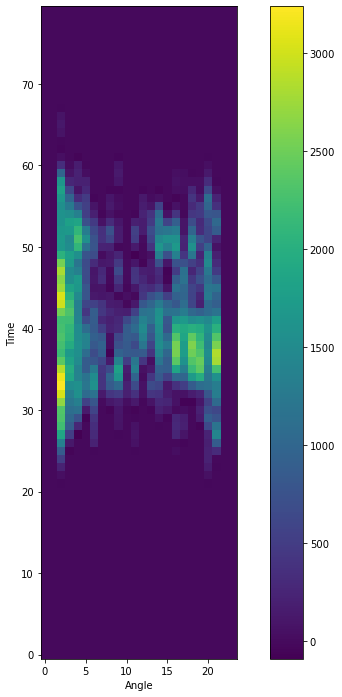

In [50]:
fig, ax = plt.subplots(figsize=(12, 12))
im = plt.imshow(images[10][:,:,0],origin='lower')
plt.ylabel('Time')
plt.xlabel('Angle')
plt.colorbar(im)
plt.show()

## Define a Convolutional Autoencoder

What is an autoencoder? In using a traditional clustering approach, we might pre-select a subset of features to do the clustering on. We did this when we only had a limited number of flourescent channels in our spectra. However, with our scattering images, if we include every pixel this this leaves us with 1920 dimensions. Research has shown that cluster analysis can perform better if we reduce the number of dimensions. There are many ways to perform dimenion reduction, but a technique known as autoencoders use the power of neural networks to extract non-linear relationships between 'channels' [nodes] and learn an appropriate latent space through the process of compression and expansion. These processes are known as encoding and decoding respectively. By using the Keras functional API in Tensorflow we can design our own autoencoder to compress and then decompress the original instrument response. We then perform cluster analysis on this latent [compressed] space. Figure xx provides an example schematic of this operation. 

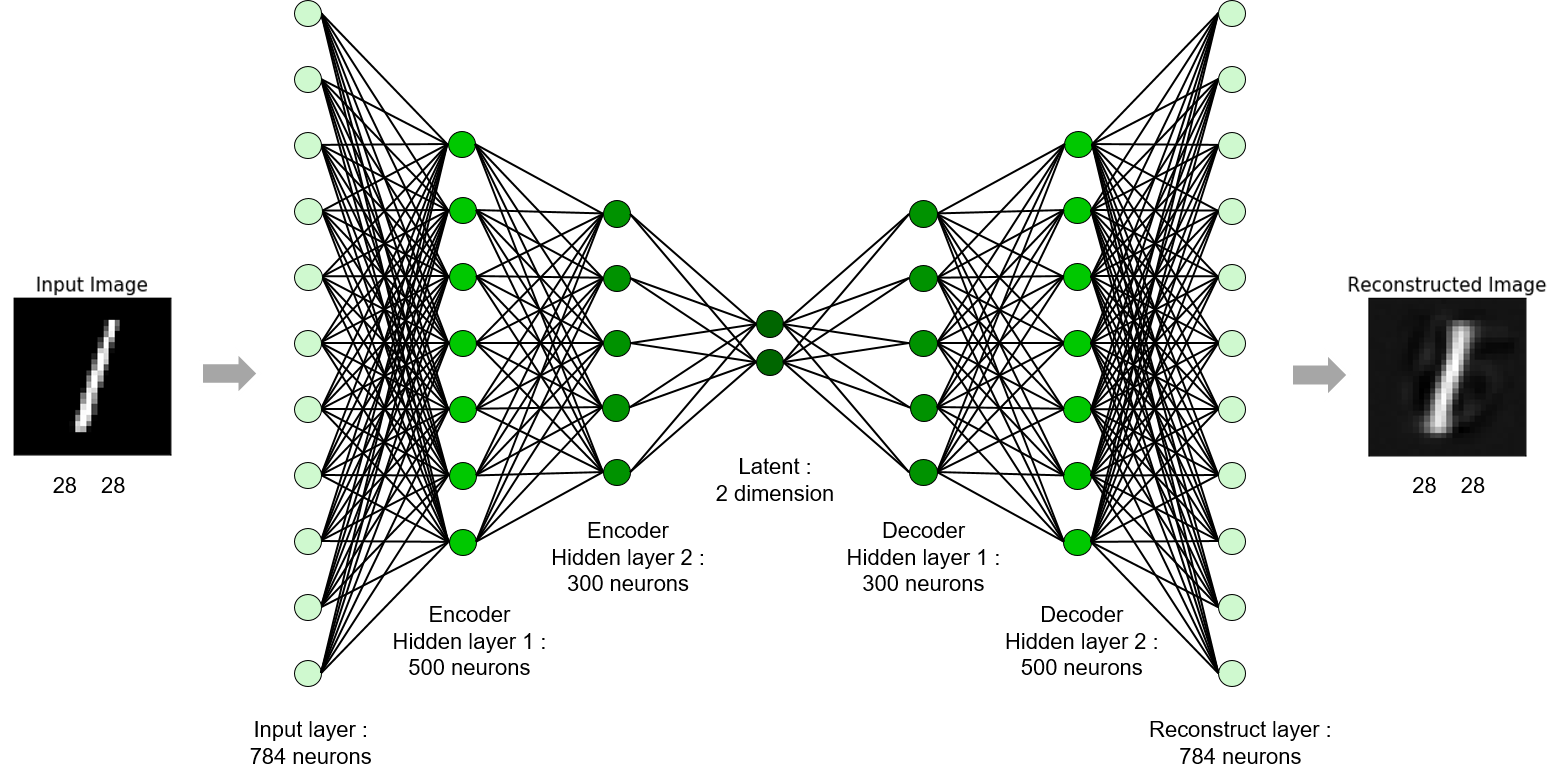
In our exercises we build a traditional autoencoder. Whilst a traditional AE reconstructs the input through a fixed latent space, a variational autoencoder [VAE] reconstructs the input through a probalistic representation. Essentially this means the latent space becomes a smooth 'surface' and transecting across that surface allows you to generate new outputs [e.g. images]. This is the basis of generative methods, but also in theory provides a more flexible variant for reconstructing ms signals. The devil is in the code detail, which have been taken and modified from either the Tensorflow and/or Keras documentation where appropriate. This is beyond the scope of this class but I can provide an example where requested. 

The figure above provides an example of where each node represents a specific pixel. How are colvolutional autoencoders different? The following image illustrates the difference. An image clearly presents a range of spatial relationships that are important to the features we wish to learn and detect. For example, this might include sharp edges or rounded features. But how do we extract those features. CNNs allow us to do this. In layman terms, we create filters that summarise different spatial relationships. One filter may capture the shard edges whilst another rounded features. We can define a small or large number of such filters and then combine them in smaller and smaller spaces to create a squashed representation of our image. 

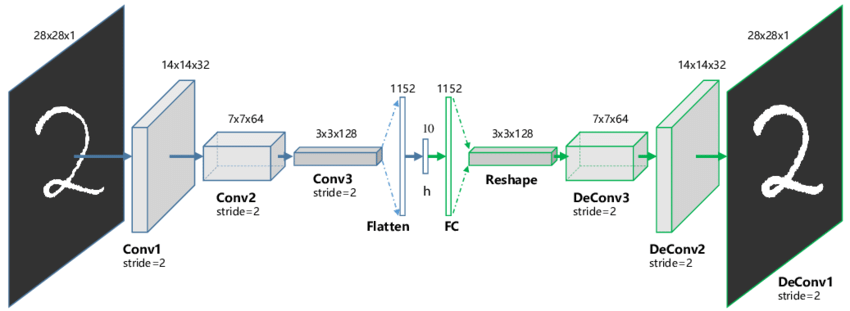


But what does this look like in code?

In the following code block we define our CNN autoencoder. In this instance I have specified my archiecture using:
 - Number of layers
 - Number of filters per layer
 - The strides 
 - The pooling strategy
 - The activation function

Take some time to read through the structure. Notice how we connect our layers together to build the model. I have purposefully kept them seperate to more easily identify the latent layer.

In [51]:
filter1_units=64
filter2_units=88
latent_dim_units=20

original_inputs = tf.keras.Input(shape=(80,24,1), name="encoder_input")

variance_scale=0.3
init = tf.keras.initializers.VarianceScaling(scale=variance_scale, mode='fan_in',distribution='uniform')
layer1_cnn = layers.Conv2D(filter1_units, (3, 3), activation='relu', kernel_initializer=init, padding='same', strides=2)(original_inputs)
layer1_cnn = layers.MaxPool2D(pool_size=(2, 2))(layer1_cnn)
layer2_cnn = layers.Conv2D(filter2_units, (3, 3), activation='relu', kernel_initializer=init, padding='same', strides=2)(layer1_cnn)
layer2_cnn = layers.MaxPool2D(pool_size=(2, 2))(layer2_cnn)

#now add a dense layer
layer3_cnn=layers.Flatten()(layer2_cnn)
latent_layer = layers.Dense(latent_dim_units, activation='relu')(layer3_cnn)
encoder_cnn = tf.keras.Model(inputs=original_inputs, outputs=latent_layer, name="encoder_cnn")

latent_inputs_cnn = tf.keras.Input(shape=(latent_layer.shape[1],), name="latent_input")
dec_layer1_cnn=layers.Dense(layer3_cnn.shape[1], activation='relu')(latent_inputs_cnn)
# convert the dense layer to reshape as a cube
dec_layer2_cnn=layers.Reshape((layer2_cnn.shape[1], layer2_cnn.shape[2], layer2_cnn.shape[3]))(dec_layer1_cnn)
# perform upsampling as the inverse of max pooling
dec_layer3_cnn = layers.Conv2DTranspose(filter2_units, (3, 3),output_padding=(1,2), activation="relu", kernel_initializer=init, padding='same', strides=(2,3))(dec_layer2_cnn)
dec_layer4_cnn = layers.Conv2DTranspose(filter1_units, (3, 3), activation="relu", kernel_initializer=init, padding='same', strides=2)(dec_layer3_cnn)
dec_layer5_cnn = layers.Conv2DTranspose(filter1_units, (3, 3), activation="relu", kernel_initializer=init, padding='same', strides=2)(dec_layer4_cnn)
#  now create the final transpose layer
decoder_output = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', kernel_initializer=init, padding='same', strides=2)(dec_layer5_cnn)
decoder_cnn = tf.keras.Model(inputs=latent_inputs_cnn, outputs=decoder_output, name="decoder_cnn")

# Define VAE model.
outputs = decoder_cnn(latent_layer)
cnn_ae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="cnn_ae")
lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
cnn_ae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())


Print a summary of the autoencoder. take a look at the change in dimensions as we move through the encoder and then decoder

In [52]:
cnn_ae.summary()

Model: "cnn_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 80, 24, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 12, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 6, 64)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 3, 88)         50776     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 1, 88)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 440)               0    

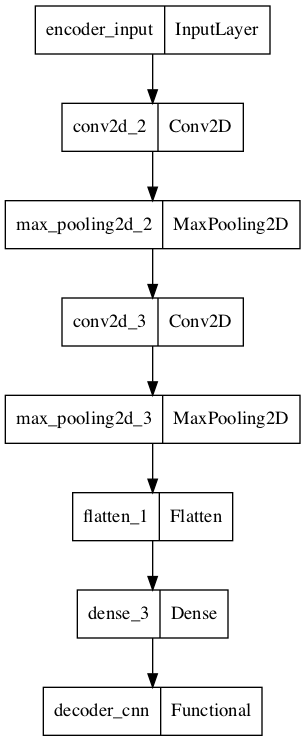

In [53]:
from tensorflow.keras.utils import plot_model
plot_model(cnn_ae)

We can now define a training and test set of data. As the CNN autoencoder learns from the data we feed it, you will see the change in loss.

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(images, test_size=0.2)

Now go ahead and fit the model. This one line of code below takes our architecture and fits to the data. You will see the progress of each epoc printed to the screen. 

In [10]:
cnn_ae.fit(x_train, x_train,epochs=10,batch_size=32,validation_data=(x_test, x_test))

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
249/250 [============================>.] - ETA: 0s - loss: 209527.7500WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f85b9d24ef0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the f

## What is wrong here???
As you observe the training loss, do the numbers make any sense? Have a look back at the proposed architecture. Notice how on the final layer we have defined a 'sigmoid' activation function. Take a look at the following picture that compares a sigmoid and relu activation function, since both are used in our network. 

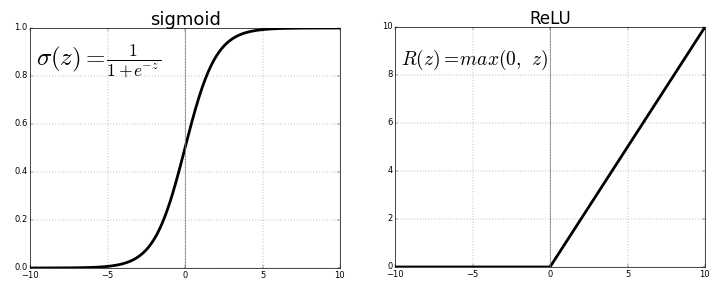

The sigmoid function keeps everything between 0-1, whilst the relu function keeps values positive. 

We havent actually normalised our image pixels. So we can do that now. In the following code, we normalise each entry by the maximum pixel intensity.


In [55]:
data=plair_df.iloc[:, 36::].to_numpy()
data=data[~np.all(data == 0, axis=1)]

data=data/np.max(data,axis=1)[:,None]

images=data.reshape(data.shape[0],80,24,1)

Now we can plot the image again, but notice the new scale. 

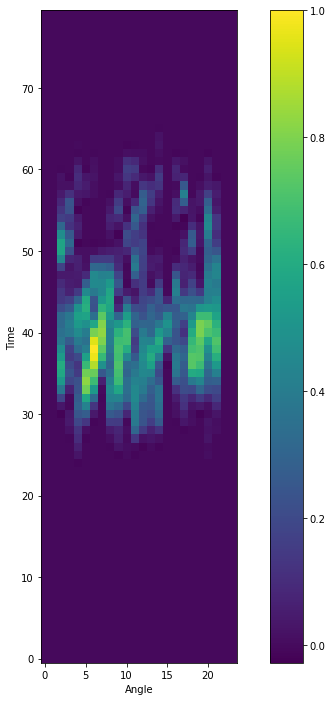

In [56]:
fig, ax = plt.subplots(figsize=(12, 12))
im = plt.imshow(images[100][:,:,0],origin='lower')
plt.ylabel('Time')
plt.xlabel('Angle')
plt.colorbar(im)
plt.show()

Now we can go ahead and re-create a train and test set and then refit our autoencoder. What now happens to the values for the loss function?

In [57]:
x_train, x_test = train_test_split(images, test_size=0.2)

In [58]:
history=cnn_ae.fit(x_train, x_train,epochs=10,batch_size=32,validation_data=(x_test, x_test))

Epoch 1/10
175/175 [==============================] - 6s 31ms/step - loss: 0.2244 - val_loss: 0.2227
Epoch 2/10
175/175 [==============================] - 5s 28ms/step - loss: 0.2140 - val_loss: 0.1890
Epoch 3/10
175/175 [==============================] - 5s 28ms/step - loss: 0.1195 - val_loss: 0.0637
Epoch 4/10
175/175 [==============================] - 5s 28ms/step - loss: 0.0453 - val_loss: 0.0346
Epoch 5/10
175/175 [==============================] - 5s 28ms/step - loss: 0.0303 - val_loss: 0.0274
Epoch 6/10
175/175 [==============================] - 5s 29ms/step - loss: 0.0256 - val_loss: 0.0244
Epoch 7/10
175/175 [==============================] - 5s 28ms/step - loss: 0.0231 - val_loss: 0.0222
Epoch 8/10
175/175 [==============================] - 5s 28ms/step - loss: 0.0211 - val_loss: 0.0204
Epoch 9/10
175/175 [==============================] - 5s 28ms/step - loss: 0.0195 - val_loss: 0.0191
Epoch 10/10
175/175 [==============================] - 5s 28ms/step - loss: 0.0185 - val_lo

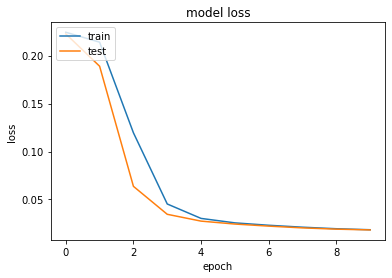

In [59]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing the output of the autoencoder. 

Now we might aswell visualise how 'good' our autoencoder is. For this we can pass an image to the autoencoder, plot the reconstructed image next to the original image but also take a look at our latent space. But how do we extract the latent space? We need to use just the encoder portion of our autoencoder. As you will see in the following snippets of code, we can use our new models we have seperately specified and now training to predict both the latent space and reconstructured image. 

In [60]:
latent_space=encoder_cnn.predict(images)

In [61]:
reconstructed_images=cnn_ae.predict(images)

Now let us look at a specific image. Change the image index and see how the graphs respond.

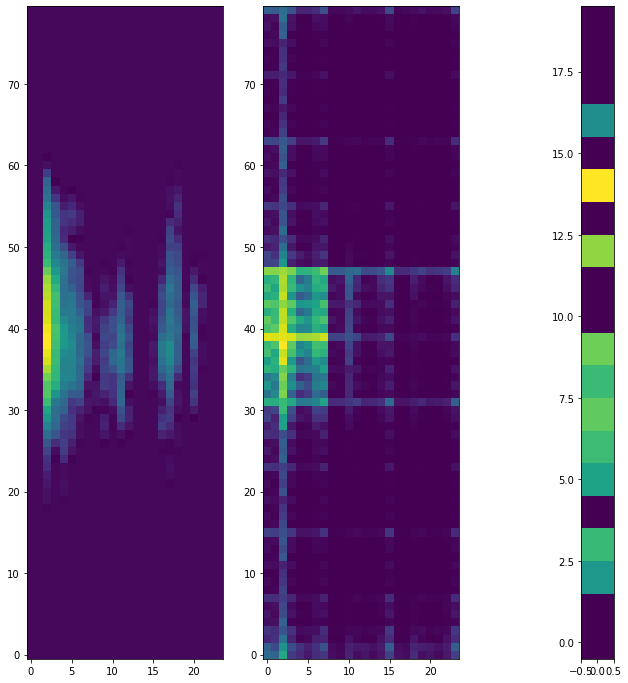

In [62]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12, 12))
im1 = ax1.imshow(images[3050][:,:,0],origin='lower')
im2 = ax2.imshow(reconstructed_images[3050][:,:,0],origin='lower')
im3 = ax3.imshow(latent_space[3050][:,None],origin='lower')

plt.show()

## Exercise 1

<div class="alert alert-block alert-success">
<b>  <a name="Exercise1"></a>  </b> 

a) Decrease the number of filters and observe any change in the reconstructed image and evolution of training loss

b) Increase the number of epochs

c) Increase the batch size.
</div>

## Perform clustering on the latent space

Now that we have created a latent representation of our images, lets try to cluster them! We are not using a huge dataset here so we can use hierarchical agglomerative clustering and then 

In [63]:
from sklearn.cluster import AgglomerativeClustering
HCA_model = AgglomerativeClustering(n_clusters=6)

In [64]:
# Pre-process the latent space using StandardScaler.
scaler = StandardScaler()
scaler.fit(latent_space)
processed_cnn_data = scaler.transform(latent_space)

# Now perform cluster analysis using fastcluster. 
HCA_model.fit(processed_cnn_data)

cnn_labels=HCA_model.labels_

In [65]:
copy_of_df['CNN_cluster_labels']=cnn_labels
copy_of_df.iloc[:, 1918:].head()

,Pix_1918,Pix_1919,CNN_cluster_labels
0,0.0,0.0,1
1,0.0,0.0,1
2,0.0,0.0,2
3,0.0,0.0,1
4,0.0,0.0,1


Now we can extract an average scattering profile of each cluster and then produce an 'average' image. What happens when you extract different cluster labels?

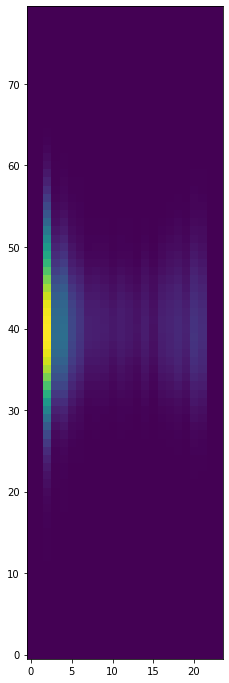

In [66]:
subset_df=copy_of_df[copy_of_df['CNN_cluster_labels']==0]
data_subset=subset_df.iloc[:, :-1].to_numpy()
data_subset=data_subset[~np.all(data_subset == 0, axis=1)]
data_subset=data_subset/np.max(data_subset,axis=1)[:,None]
#now create an average scattering profile
data_average=np.mean(data_subset, axis=0)
average_image=data_average.reshape(80,24)

fig, (ax1) = plt.subplots(1,1,figsize=(12, 12))
im1 = ax1.imshow(average_image,origin='lower')
plt.show()

In [67]:
data_with_labels = np.concatenate((data, cnn_labels[:,None]), axis=1)

In [68]:
data_with_labels.shape

(7000, 1921)

## Define an LSTM - Autoencoder.

The following rather complicated figure illustrates the connections between the layers

![](https://raw.githubusercontent.com/loftytopping/Aerosol_CDT_modelling/master/data/images/lstm_autoencoder.png)



The original image can be [found here](https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352).


In [69]:
filter1_units=64
filter2_units=32
latent_dim_units=20
timesteps=80
n_features=24

original_inputs = tf.keras.Input(shape=(timesteps,24), name="lstm_encoder_input")
layer1_lstm = layers.LSTM(filter1_units,return_sequences=True)(original_inputs)
layer1_lstm = layers.Dropout(rate=0.2)(layer1_lstm)
layer2_lstm = layers.LSTM(filter2_units, return_sequences=False)(layer1_lstm)
#encoder_lstm = tf.keras.Model(inputs=original_inputs, outputs=layer2_lstm, name="encoder_lstm")
#latent_inputs_lstm = tf.keras.Input(shape=(filter2_units), name="lstm_latent_input")
dec_layer1_lstm = layers.RepeatVector(timesteps)(layer2_lstm)
dec_layer2_lstm = layers.LSTM(filter2_units, return_sequences=True)(dec_layer1_lstm)
dec_layer3_lstm = layers.LSTM(filter1_units, return_sequences=True)(dec_layer2_lstm)
decoder_output = layers.TimeDistributed(layers.Dense(n_features))(dec_layer3_lstm)
#decoder_lstm = tf.keras.Model(inputs=latent_inputs_lstm, outputs=decoder_output, name="decoder_lstm")

# Define model.
#outputs = decoder_lstm(latent_layer)
lstm_ae = tf.keras.Model(inputs=original_inputs, outputs=decoder_output, name="lstm_ae")
lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
lstm_ae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())


In [75]:
lstm_ae.summary()

Model: "lstm_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_encoder_input (InputLa  [(None, 80, 24)]         0         
 yer)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 80, 64)            22784     
                                                                 
 dropout_1 (Dropout)         (None, 80, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 80, 32)           0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 80, 32)            8320

We can also display the model structure, as we did for our CNN-AE

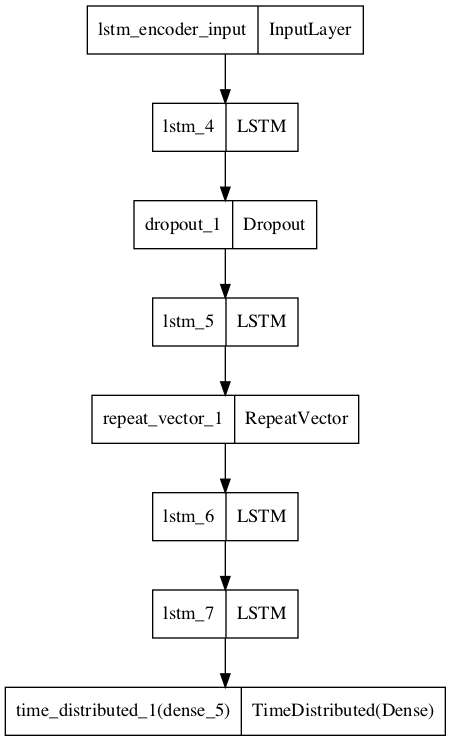

In [70]:
plot_model(lstm_ae)

Now lets train this on the same dataset we used for our previous model.

In [71]:
history_lstm=lstm_ae.fit(x_train, x_train,epochs=10,batch_size=32,validation_data=(x_test, x_test))

Epoch 1/10
175/175 [==============================] - 15s 64ms/step - loss: 0.0112 - val_loss: 0.0066
Epoch 2/10
175/175 [==============================] - 10s 57ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 3/10
175/175 [==============================] - 10s 57ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 4/10
175/175 [==============================] - 10s 58ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 5/10
175/175 [==============================] - 10s 58ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 6/10
175/175 [==============================] - 10s 59ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 7/10
175/175 [==============================] - 10s 59ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 8/10
175/175 [==============================] - 10s 59ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 9/10
175/175 [==============================] - 10s 58ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 10/10
175/175 [==============================] - 10s 58ms/step - loss: 0.004

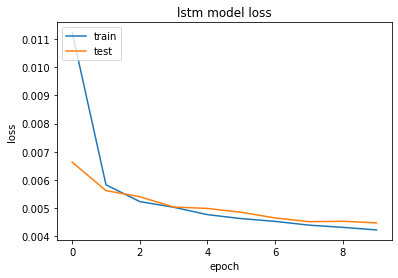

In [72]:
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('lstm model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Lets try to predict some reconstructed images

In [73]:
reconstructed_image_lstm=lstm_ae.predict(images)

But how do we access the latent space??

In the CNN autoencoder we explicitly defined our encoder and decoder portions. Once connected and trained, this allowed us to use that trained model directly. We have not done that here. Rather, we have explicitly defined our autonencoder as one model. How do we then access the latent space? In the following code block we access specific layers from our autoenoder, defined as a new model. Once defined, we can then predict.

In [74]:
latent_space_model =  tf.keras.Model(inputs=lstm_ae.input, outputs=lstm_ae.get_layer('lstm_1').output)
latent_space_lstm = latent_space_model.predict(images)

ValueError: No such layer: lstm_1. Existing layers are: ['lstm_encoder_input', 'lstm_4', 'dropout_1', 'lstm_5', 'repeat_vector_1', 'lstm_6', 'lstm_7', 'time_distributed_1'].

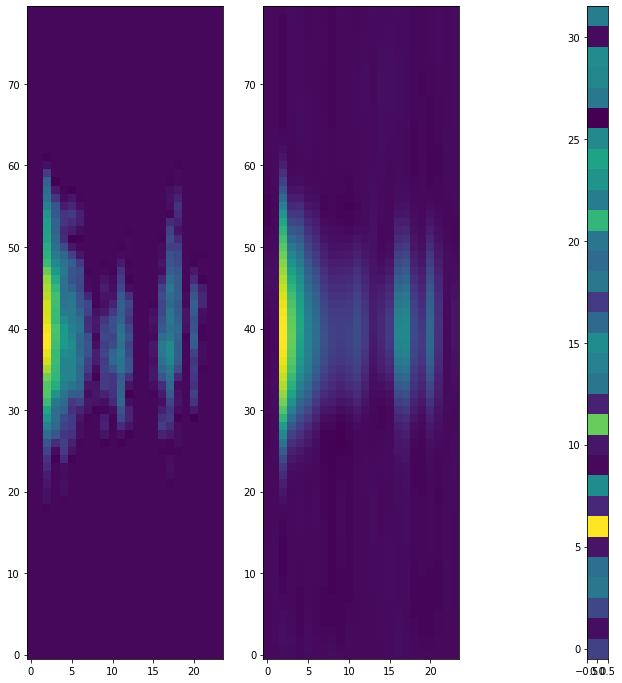

In [33]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12, 12))
im1 = ax1.imshow(images[3050][:,:,0],origin='lower')
im2 = ax2.imshow(reconstructed_image_lstm[3050][:,:],origin='lower')
im3 = ax3.imshow(latent_space_lstm[3050][:,None],origin='lower')

plt.show()

## Exercise 2

<div class="alert alert-block alert-success">
<b>  <a name="Exercise2"></a>  </b> 
    
Much as we did for our CNN-AE, get a feel for how the model behaves by conducting the following experiments:
    
a) Decrease the number of filters and observe any change in the reconstructed image and evolution of training loss

b) Increase the number of epochs

c) Increase the batch size.
</div>

## Exercise 3

<div class="alert alert-block alert-success">
<b>  <a name="Exercise3"></a>  </b> 
    
Now we have the latent space generated by our model, in this exercise we ask you to complete the generation of cluster labels by applyng hierarchical agglomerative clustering. Using the StandardScaler function from Sci-kit learn, generate the labels for 6 clusters and then save those clusters to the dataframe 'copy_of_df' under a new column:'LSTM_cluster_labels'

Once you have done this, plot the 'average' image profile of one of the clusters using the .imshow plotting function of Matplotlib as we have done before.
    
By saving your cluster labels to our dataframe, we are then going to use a confusion matrix to try and understand the similarity between using a CCN and LSTM autoencoder.

</div>

In [35]:
# Generate cluster labels on the latent space and save to our dataframe 'copy_of_df'
#--------------------INSERT CODE HERE --------------------
# Pre-process the latent space using StandardScaler.
scaler = StandardScaler()
scaler.fit(latent_space_lstm)
processed_lstm_data = scaler.transform(latent_space_lstm)

# Now perform cluster analysis using fastcluster. 
HCA_model_lstm = AgglomerativeClustering(n_clusters=6)
HCA_model_lstm.fit(processed_lstm_data)
lstm_labels=HCA_model_lstm.labels_

copy_of_df['LSTM_cluster_labels']=lstm_labels
#----------------------------------------------------------

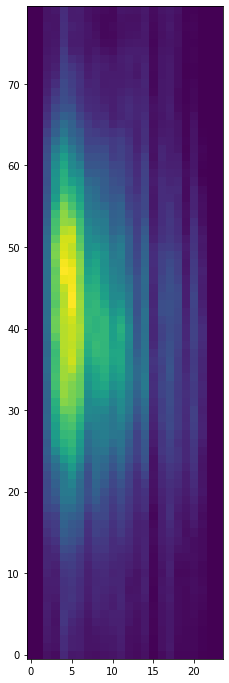

In [36]:
# Plot the 'average' image profile of individual cluster members
#--------------------INSERT CODE HERE --------------------
subset_df=copy_of_df[copy_of_df['LSTM_cluster_labels']==3]
data_subset=subset_df.iloc[:, :-2].to_numpy()
data_subset=data_subset[~np.all(data_subset == 0, axis=1)]
data_subset=data_subset/np.max(data_subset,axis=1)[:,None]
#now create an average scattering profile
data_average=np.mean(data_subset, axis=0)
average_image=data_average.reshape(80,24)

fig, (ax1) = plt.subplots(1,1,figsize=(12, 12))
im1 = ax1.imshow(average_image,origin='lower')
plt.show()
#----------------------------------------------------------

## Compare the cluster solutions between an LSTM and CNN approach 

We have just applied two different flavours of autoencoder to the same dataset. Now we can use a confusion matrix to try to understand where any crossovers occur. We can do this using two simple lines of code as per the below.

In [37]:
from sklearn.metrics import confusion_matrix
#Generate the confusion matrix
cf_matrix = confusion_matrix(lstm_labels, cnn_labels, normalize='true')

Now we have generated the confusion matrix, we can plot this using the Seaborn library. What do these results mean?

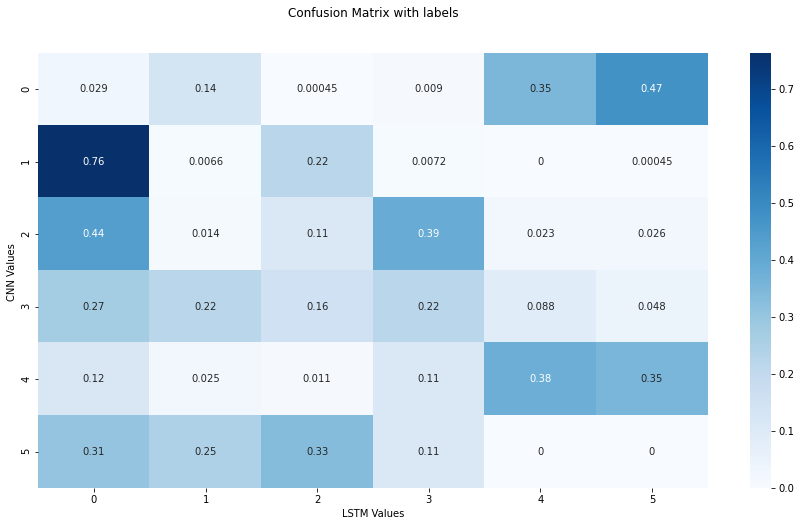

In [38]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('LSTM Values')
ax.set_ylabel('CNN Values ')
plt.show()

How might we compare the average profiles of different clusters? Try to complete the code snippet given below

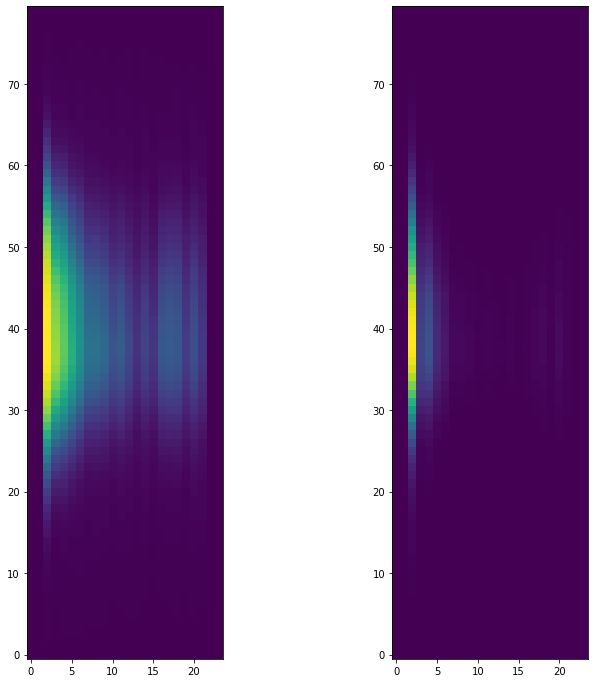

In [42]:
#--------------------INSERT CODE HERE --------------------
subset_df_cnn=copy_of_df[copy_of_df['CNN_cluster_labels']==2]
data_subset_cnn=subset_df_cnn.iloc[:, :-2].to_numpy()
#now create an average scattering profile
data_average_cnn=np.mean(data_subset_cnn, axis=0)
average_image_cnn=data_average_cnn.reshape(80,24)

subset_df_lstm=copy_of_df[copy_of_df['LSTM_cluster_labels']==0]
data_subset_lstm=subset_df_lstm.iloc[:, :-2].to_numpy()
#now create an average scattering profile
data_average_lstm=np.mean(data_subset_lstm, axis=0)
average_image_lstm=data_average_lstm.reshape(80,24)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 12))
im1 = ax1.imshow(average_image_cnn,origin='lower')
im2 = ax2.imshow(average_image_lstm,origin='lower')

plt.show()
#----------------------------------------------------------